<a href="https://colab.research.google.com/github/kteppris/RealWaste/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training von Deep Learning Modellen mit PyTorch Lightning

In unserem Projekt werden PyTorch, Torchvision und PyTorch Lightning als wichtige Werkzeuge für die Entwicklung und das Training der CNNs verwendet.

PyTorch ist ein flexibles und dynamisches Open-Source Deep-Learning-Framework, das von Forschern und Entwicklern aufgrund seiner Einfachheit und Effizienz geschätzt wird. Es bietet eine intuitive API, die es ermöglicht, komplexe neuronale Netzwerkarchitekturen einfach zu erstellen und zu trainieren. Die Flexibilität von PyTorch ermöglicht es, CNN-Modelle zu entwerfen und anzupassen, um sie an die spezifischen Anforderungen der Müllklassifizierungsaufgabe anzupassen. [The Linux Foundation 2024](https://pytorch.org/)

Torchvision ist eine Bibliothek, die auf PyTorch aufbaut und speziell für Computer Vision-Anwendungen entwickelt wurde. Sie bietet eine Vielzahl von nützlichen Funktionen und Werkzeugen, darunter vortrainierte Modelle, Datensatz-Loader und Bildtransformationen. Torchvision wird in diesem Projekt genutzt, um auf vortrainierte CNN-Modelle wie Inception oder DenseNet zuzugreifen. Diese vortrainierten Modelle dienen als Ausgangspunkt für folgende Trainings und ermöglichen es, von bereits gelernten Merkmalen zu profitieren und somit die Trainings- und Rechenzeit zu verkürzen. So können bereits in wenigen Epochen hohe Klassifikationsgenauigkeiten erzielt werden. [The Linux Foundation 2024](https://pytorch.org/vision/stable/index.html)

PyTorch Lightning ist ein Framework, das darauf abzielt, die Entwicklung von PyTorch-Modellen zu vereinfachen und zu standardisieren, indem es bewährte Praktiken und Designmuster fördert. Es bietet eine leichtgewichtige und modulare API, die es ermöglicht, Trainings- und Evaluierungsschleifen effizient zu organisieren und zu verwalten. Durch die Verwendung von PyTorch Lightning kann der Code strukturiert, wieder verwendbare Komponenten erstellt und das Training der CNN-Modelle skalierbarer und einfacher gemacht werden. [Lightning AI 2024](https://lightning.ai/docs/pytorch/stable/)

Single et al. 2023 haben in ihrem Paper Modelle unter Verwendung der folgenden Backbones trainiert: VGG-16, DenseNet121, Inception V3, InceptionResNet V2 sowie MobileNetV2. Da Single et al. ihren Code nicht veröffentlicht haben, werden zunächst sowohl das beste, Inception V3 mit einer Accuracy von 89.19%, als auch das schlechteste Modell, Vgg16 mit einer Accuracy von 85,65%, ebenfalls trainiert, um die technischen Einstellungen zu überprüfen sowie über eine Referenz für die nachfolgend trainierten Modelle zu verfügen. 
Da dieses Projekts zeitlichen Limitationen unterliegt, wird unter Rückbezug auf das paper "A Systematic Review of Machine Learning Approaches for Trash Classification" von [Vidhya 2023](https://ieeexplore.ieee.org/document/10125688) eine Auswahl der weiterführen zu trainierenden Modelle getroffen. Des weiteren unterliegt dieses Projekt der Herausforderung einer begrenzten Rechenkapazität. Um diese zu bewältigen, wird sich bei der Auswahl der Backbones auf die in torchvision vorhandenen Backbones beschränkt. Torchvision trägt weitergehend zu der Einheitlichkeit des Codes sowie einer aufwandsarmen Implementierung bei. 
Basierend auf den soeben genannten Überlegungen werden zusätzlich zu Inception V3 und VGG16 die folgenden Modelle trainiert, um eine umfassende Bewertung der Backbones für die Bildklassifizierungsaufgabe zu ermöglichen. 

AlexNet zeichnet sich durch seine Pionierarbeit in der Einführung von CNNs für Bilderkennungsaufgaben aus, wobei seine tiefe Architektur und die Verwendung von Dropout-Regularisierung zu einer bemerkenswerten Leistungssteigerung bei der Bildklassifizierung führten, indem eine Vielzahl von Merkmalen aus den Bildern extrahiert und deren Generalisierungsfähigkeit verbessert wurde.

DenseNet201 hebt sich durch sein dichtes Verbindungsverfahren hervor, bei dem jede Schicht direkte Verbindungen zu allen vorherigen Schichten aufweist, was zu einem starken Fokus auf den Informationsfluss innerhalb des Netzwerks führt und die Effektivität der Merkmalsextraktion und Klassifizierung bei Bildaufgaben erheblich verbessert.

ResNet50 hebt sich durch seine innovative Residual-Lernstruktur hervor, die es ermöglicht, sehr tiefe neuronale Netzwerke zu trainieren, indem sie den Informationsfluss durch das Netzwerk erleichtert und das Auftreten von verschwindenden oder explodierenden Gradienten reduziert. Diese Architektur führt zu einer effizienten Merkmalsextraktion und einer verbesserten Genauigkeit bei der Bildklassifizierung sowie anderen visuellen Aufgaben.

XXX Simple CNN Erläuterung + Vision Transformer XXX

# Setup und übergreifende Methoden und Klassen

## Datenpfade setzen

- Setup der Pfade

In [40]:
import sys
from pathlib import Path

# Funktion, die prüft, ob dieses Skript in Colab ausgeführt wird
def in_colab():
    # sys beinhaltet alle bereits geladenen Pakete
    return 'google.colab' in sys.modules  # google.colab wird automatisch in Colab vorgeladen, daher Indiz für Colab Environment

code_repo_path = Path("/content/drive/MyDrive/MADS/RealWaste") if in_colab() else Path.cwd()

if in_colab():
    # Google Drive einbinden zum persistieren von Code, Daten und Ergebnissen
    from google.colab import drive
    drive.mount('/content/drive')
    if not code_repo_path.exists():
        raise FileNotFoundError("Code und Datenordner konnte nicht gefunden werden. Bitte zuerst das Notebook '1_Hauptnotebook.ipynb' ausführen.")
    else:
        # wechsle Arbeitsverzeichnis zu code_repo_path
        %cd {code_repo_path}
        print(f"Wechsel Arbeitsverzeichnis zu {Path.cwd()}")
        %pip install -r requirements.txt
else:
    print("Stellen Sie sicher, dass das richtige Venv als Kernel ausgewählt ist,\nwelches wie in '1_Hauptnotebook.ipynb' beschrieben erstellt wurde.")

train_data_path = code_repo_path / "data"
our_test_data_path = code_repo_path / "our_test_data"

Stellen Sie sicher, dass das richtige Venv als Kernel ausgewählt ist,
welches wie in '1_Hauptnotebook.ipynb' beschrieben erstellt wurde.


## Konfigurierbare Datamodule Klasse

- Basis des Datenmodules, sodass später nurnoch transformationen angepasst werden müssen

In [41]:
from pytorch_lightning import LightningDataModule
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torch
import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

class ConfigurableDataModule(LightningDataModule):
    def __init__(self, train_data_dir: str, test_data_dir: str, batch_size: int, train_transform, val_test_transform, workers=-1, seed=42):
        super().__init__()
        self.workers = os.cpu_count() if workers == -1 else workers
        self.train_data_dir = train_data_dir  # Daten von RealWaste Datensatz
        self.test_data_dir = test_data_dir  # Unsere Testdaten
        self.batch_size = batch_size
        self.train_transform = train_transform  # Training Transformation, die auch Rotate etc. beinhalten
        self.val_test_transform = val_test_transform  # Val/Test Transformation die normalerweise nur to tensor, normalisierung etc. beinhalten
        self.seed = seed # Seed zum gewährleisten von gleichen Splits des Trainingsdatensatzes

    def setup(self, stage=None):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)

        # Setup des Trainings und Validierungsdatensates
        if stage in (None, "fit"):
            # Laden des Training Datensatzes mit den zugehörigen Transformierungen
            full_train_dataset = ImageFolder(root=self.train_data_dir, transform=self.train_transform)
            
            # Ermitteln der Indizes für Train/Val Split nach gleichen Verfahren wie bei den klassischen ML Methoden
            train_indices, val_indices = self.stratified_split(full_train_dataset)

            # Train Datensatz setzen basierend auf den bestimmten Indizes
            self.train_dataset = Subset(full_train_dataset, train_indices)

            # Validation Datensatz Laden wie zuvor der Trainingsdatensatz, aber mit anderen Transformierungen
            # Dies ermöglicht es, beispielsweise Rotate nur auf die Trainingsdaten anzuwenden, aber normalisierung auf beide
            full_val_dataset = ImageFolder(root=self.train_data_dir, transform=self.val_test_transform)
            # Setzen des Validierungsdatensatzes basierend auf den Indizes
            self.val_dataset = Subset(full_val_dataset, val_indices)

        # Setup unseres Testdatensates
        if stage == "test":
            # Nutzung der Val/Test Transfomierungen
            self.test_dataset = ImageFolder(root=self.test_data_dir, transform=self.val_test_transform)

    def stratified_split(self, dataset):
        # Ermittelt Indizes für Train/Test split mit gleicher Verteilung der Klassen und festgesetzten seed
        targets = np.array([sample[1] for sample in dataset.samples])

        X_dummy = np.zeros(len(targets))
        # 20% Test, 80% Train
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=self.seed)
        
        for train_index, val_index in sss.split(X_dummy, targets):
            return train_index, val_index

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.workers)


## Base Lightning Module

- Basis für das Training und die individuellen Modelle
- Output Ordner:
    - Speichern von CSV logs, model checkpoints, Bilder aus Validierung und Test
- Metriken:
    - Acc, Precision, Recall und F1 Score: Alle Macro gewichtet
- Loss:
    - Cross Entropy
- Logging:
    - Läuft über später reingegebene Callbacks
- Step/Epoch
    - Steps sind die einzelnen Schritte, wo jeweils eine Bach verarbeitet wird und beim Training Gewichte angepasst werden (Backpropagation)
    - Eine Epoch ist rum wenn alle Bilder eines der Subdatensätze verwendet wurden. Hier wird der Epochdurchschnitt der Metriken berechnet.
    - on_... sind Callback functions von Lightning die automatisch nach den train/val/test epochen aufgerufen werden
- Log images:
    - Custom Function die mit 10% wahrscheinlichkeit Bilder während der Validierung/Test logged. Diese werden auch beschriftet, sodass man sie später überprüfen kann

In [42]:
from PIL import ImageDraw
import pytorch_lightning as pl
import torch
import torchmetrics
import torchvision
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_tensor
import random
import time
import shutil
from pathlib import Path

class BaseWasteClassifier(pl.LightningModule):
    CLASS_NAMES = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

    def __init__(self, num_classes: int, results_dir="results"):
        super().__init__()
        self.num_classes = num_classes
        # Klassennamen bekommen, für den result Ordner namen
        model_class_name = self.__class__.__name__
        
        # Ergebnisspfade definieren
        self.results_dir = Path(results_dir) / model_class_name
        self.models_dir = self.results_dir / "models"
        self.images_dir = self.results_dir / "images" 
        self.logs_dir = self.results_dir / "logs"
        self.version = None # For later the current Version

        # Pfade erstellen
        self.results_dir.mkdir(parents=True, exist_ok=True)
        self.models_dir.mkdir(parents=True, exist_ok=True)
        self.images_dir.mkdir(parents=True, exist_ok=True)
        self.logs_dir.mkdir(parents=True, exist_ok=True)

        # Platzhalter wo später das tatsächlich Modell hinkommt
        # Wird bei konkreten Klassen definiert
        self.model = None
        
        # Neue Konvention nach: https://github.com/Lightning-AI/pytorch-lightning/pull/16520
        self.validation_step_outputs = []
        # self.last_validation_step_outputs = []
        self.test_step_outputs = []
        # self.last_validation_step_outputs = []
        
        # Metrik tracker initialisieren
        # Nutzung von macro average zum beachten der ungleichen Anzahl von Fotos in den Klassen
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes, average='macro')
        self.precision = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='macro')
        self.recall = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='macro')
        self.f1_score = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='macro')


    def forward(self, x):
        # Diese Method ist quasi "abstract" und muss von der jeweiligen konkreten Klasse definiert werden
        raise NotImplementedError("This method should be overridden by subclasses.")
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[0]  
        loss = torch.nn.functional.cross_entropy(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        
        # Für das Training berechnen wir die Metriken in jedem step, sodass wir live to Fortschritt sehen
        acc = self.accuracy(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)
        f1 = self.f1_score(preds, y)  
        
        # Logging der Metriken
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        start_time = time.perf_counter()
        outputs = self(x)
        inference_time = time.perf_counter() - start_time
        
        # Durchschnittliche Inferenzzeit pro Bild Berechnen und loggen
        avg_inference_time_per_image = inference_time / len(x)
        self.log('val_avg_inference_time_per_image', avg_inference_time_per_image)
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[0]
        
        # Die Eigenlichte Vorhersage aus den logits ermittelt (höchster Wahrscheinlichkeitswert)
        preds = torch.argmax(outputs, dim=1)
        
        # Loss Berechnen und loggen
        loss = torch.nn.functional.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        self.validation_step_outputs.append({'img': x, 'loss': loss, 'preds': preds, 'targets': y})
    
    def test_step(self, batch, batch_idx):
        x, y = batch

        start_time = time.perf_counter()
        outputs = self(x)
        inference_time = time.perf_counter() - start_time
        
        # Durchschnittliche Inferenzzeit pro Bild Berechnen und loggen
        avg_inference_time_per_image = inference_time / len(x)
        self.log('test_avg_inference_time_per_image', avg_inference_time_per_image)
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[0]
        
        # Die Eigenlichte Vorhersage aus den logits ermittelt (höchster Wahrscheinlichkeitswert)
        preds = torch.argmax(outputs, dim=1)
        
        # Loss Berechnen und loggen
        loss = torch.nn.functional.cross_entropy(logits, y)
        self.log('our_test_data_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        self.test_step_outputs.append({'img': y,'loss': loss, 'preds': preds, 'targets': y})
    
    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        # Aggregieren der Vorhersagen und Label aus allen Validierungssteps
        preds = torch.cat([x['preds'] for x in outputs], dim=0)
        targets = torch.cat([x['targets'] for x in outputs], dim=0)

        self.validation_step_outputs.clear()
        
        # Logging den Metriken basierend auf den Ergebnissen der ganzen Val Epoche
        self.log('val_acc', self.accuracy(preds, targets))
        self.log('val_precision', self.precision(preds, targets))
        self.log('val_recall', self.recall(preds, targets))
        self.log('val_f1', self.f1_score(preds, targets))

    def on_test_epoch_end(self):
        # Aggregieren der Vorhersagen und Label aus allen Teststeps
        outputs = self.test_step_outputs
        preds = torch.cat([x['preds'] for x in outputs], dim=0)
        targets = torch.cat([x['targets'] for x in outputs], dim=0)
        

        self.test_step_outputs.clear()
        
        # Log test metrics with "our_test_data_" prefix
        self.log('our_test_data_acc', self.accuracy(preds, targets))
        self.log('our_test_data_precision', self.precision(preds, targets))
        self.log('our_test_data_recall', self.recall(preds, targets))
        self.log('our_test_data_f1', self.f1_score(preds, targets))

    def configure_optimizers(self):
        # SGD, kann überschrieben werden wenn andere Optimizer gewünscht
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
        return optimizer


## PyTorch Lightning Callbacks

- Funktion die checkpoint und early stop callback vorbereit
- Reduziert das laden dieser Callbacks for jedem Training zu einer Zeile Code

In [43]:
from pathlib import Path
from PIL import Image, ImageDraw
import torchvision
from torchvision.transforms.functional import to_pil_image, to_tensor
import numpy as np
import torch
import os
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix
from pytorch_lightning.callbacks import Callback

class EnhancedSaveCallback(Callback):
    def __init__(self, monitor='val_acc', mode='max', save_image_pct=0.1):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        self.best_metric = 0 if mode == 'max' else float('inf')
        self.save_image_pct = save_image_pct

    def on_validation_end(self, trainer, pl_module):
        outputs = pl_module.last_validation_step_outputs
        print("ON_VAL_END")
        if outputs:
            current_metric = trainer.callback_metrics.get(self.monitor)
            print("ON_VAL_END_OUTPUT")
            if current_metric is not None:
                print("ON_VAL_END_OUTPUT_METRIC")
                # Prüfen ob aktuelle "monitor" Metrik die beste bisher ist -> bool yes/no
                is_best = (current_metric > self.best_metric if self.mode == 'max' else current_metric < self.best_metric)    
                if is_best:
                    print("ON_VAL_END_OUTPUT_METRIC_BEST")
                    self.best_metric = current_metric
                    self.save_confusions_matrix(pl_module, outputs, 'val')
                    self.log_images_with_labels(pl_module, outputs, 'val')

    def on_test_end(self, trainer, pl_module):
        outputs = pl_module.last_test_step_outputs
        if outputs:
            self.save_confusions_matrix(pl_module, outputs, 'test')
            self.save_images_with_labels(pl_module, outputs, 'test')

    def save_confusions_matrix(self, pl_module, outputs, phase):

        labels = torch.cat([o['targets'] for o in outputs])
        predictions = torch.cat([o['preds'] for o in outputs])
        cm = confusion_matrix(targets, predictions)
        
        logs_dir = self.prepare_paths(pl_module.logs_dir, pl_module.version, phase)
        file_path = logs_dir / f'confusion_matrix.npy'
        np.save(file_path, cm)

    def save_images_with_labels(self, pl_module, outputs, phase):
        
        # Collect images, labels, and predictions
        images = torch.cat([o['img'] for o in outputs])
        labels = torch.cat([o['targets'] for o in outputs])
        predictions = torch.cat([o['preds'] for o in outputs])
        
        image_dir = self.prepare_path(pl_module.logs_dir, pl_module.version, phase)
        
        sample_indices = np.arange(len(images))
        # Bei Validierung nur ein Teil der Bilder speichern
        if phase == "val":
            sample_size = int(len(images) * self.save_image_pct)
            sample_indices = np.random.choice(sample_indices, size=sample_size, replace=False)
        
        for idx in sample_indices:
            image, label, prediction = images[idx], labels[idx], predictions[idx]
            actual_class_name = pl_module.CLASS_NAMES[label.item()]

            pil_img = to_pil_image(image)
            draw = ImageDraw.Draw(pil_img)
            annotation_text = f'Actual: {actual_class_name},\nPredicted: {self.class_names[prediction.item()]}'
            draw.text((10, 10), annotation_text, fill="white")
            
            image_cls_dir = (image_dir / actual_class_name).mkdir(parents=True, exist_ok=True)
            file_path = image_cls_dir / f"image_{idx}.png"
            pil_img.save(file_path)

    def unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        # normalisierung vom Anfang Rückgängig machen
        image = image.clone()  
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)  
        return image
    
    def prepare_path(self, dir_path, version, phase):
        dir_phase_path = pl_module.logs_dir / version / phase
        if dir_phase_path.exists:
            shutil.rmtree(dir_phase_path)
        dir_phase_path.mkdir(parents=True, exist_ok=True)
        return dir_phase_path

In [44]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

def get_callbacks(model_checkpoint_path: str, early_stop_patience=2):
    callbacks = []

    # M
    checkpoint_callback = ModelCheckpoint(
        dirpath=model_checkpoint_path,
        filename='{epoch}-{val_loss:.2f}',
        save_top_k=1,  # Nur das beste Modell speichern
        verbose=True,
        monitor='val_loss',  # Metrik die beobachtet werden soll
        mode='min', # Niedrigere loss ist besser
    )
    callbacks.append(checkpoint_callback)

    # Stoppt des Training wenn sich val loss nicht verbessert
    early_stopping_callback = EarlyStopping(
        monitor="val_loss",  # Loss beobachten um Overfitting zu vermeiden
        mode="min",  # Loss soll minimiert werden
        patience=early_stop_patience,  # "Wartet" n Epochen ohne Verbesserung
    )
    callbacks.append(early_stopping_callback)
    
    return callbacks

## Metriken Plot Funktion

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path  
sns.set()


# Diese Funktion kann genutzt werden, um die geloggeten CSV Daten nach einem Training zu visualisieren
def make_summary_plots(logs_dir):
    metrics_df = pd.read_csv(Path(logs_dir) / 'metrics.csv')

    #     # Nach Epoch gruppieren und aggregieren der Metriken
    agg_funcs = {col: 'last' for col in metrics_df.columns if 'epoch' in col or 'val_' in col}
    metrics_df = metrics_df.groupby('epoch', as_index=False).agg(agg_funcs)

    # Plots vorbereiten
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Adjust to a single row with three columns
    fig.suptitle('Training and Validation Metrics Over Epochs')

    # Loss Funktionen 
    axs[0].plot(metrics_df['epoch'], metrics_df['train_loss_epoch'], label='Train Loss')
    axs[0].plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_ylim(0, 2.0)  # Set y-axis range for loss
    axs[0].legend()

    # Accuracy Plot
    axs[1].plot(metrics_df['epoch'], metrics_df['train_acc_epoch'], label='Train Accuracy')
    axs[1].plot(metrics_df['epoch'], metrics_df['val_acc'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1)  # Set y-axis range for percentage metrics
    axs[1].legend()

    # Precision, Recall, and F1 Score Plot
    axs[2].plot(metrics_df['epoch'], metrics_df['train_precision_epoch'], label='Train Precision')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_precision'], label='Validation Precision')
    axs[2].plot(metrics_df['epoch'], metrics_df['train_recall_epoch'], label='Train Recall')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_recall'], label='Validation Recall')
    axs[2].plot(metrics_df['epoch'], metrics_df['train_f1_epoch'], label='Train F1 Score')
    axs[2].plot(metrics_df['epoch'], metrics_df['val_f1'], label='Validation F1 Score')
    axs[2].set_title('Precision, Recall & F1 Score')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Score')
    axs[2].set_ylim(0, 1)  # Set y-axis range for percentage metrics
    axs[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Train Modell Funktion

- Initialisiert Logger
- Startet Training

In [46]:
import os
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

def train_model(model, data_module, tb_log_dir="tb_logs", max_epochs=50, logger_name="model_logs", version_name="version_0", callbacks=[]):
    # Logger definieren
    tb_logger = TensorBoardLogger(tb_log_dir, name=logger_name)
    csv_logger = CSVLogger(model.results_dir, name="logs", version=version_name)
    model.version = version_name
    
    trainer = Trainer(max_epochs=max_epochs, logger=[tb_logger, csv_logger], callbacks=callbacks)
    
    # Fit: Training und Validierung
    trainer.fit(model, datamodule=data_module)
    
    # Vorbereiten des Test Datensatzes (siehe DataModule)
    data_module.setup("test")
    # Test auf unseren Daten
    trainer.test(
        ckpt_path="best", # Nutzt die Gewichte mit der besten val loss
        model=model, 
        datamodule=data_module
    )
    
    make_summary_plots(csv_logger.log_dir)


# Training

In [9]:
%reload_ext tensorboard
%tensorboard --logdir={code_repo_path / "tb_logs"}

## Training mit Standardeinstellungen

### SimpleCNN

#### Model

In [47]:
import torch.nn as nn

class SimpleCNN(BaseWasteClassifier):
    def __init__(self, num_classes=9, lr=1e-3):
        self.lr = 1e-3
        super().__init__(num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),  # Bestätigt, dass dies für eine Eingabegröße von 224x224 korrekt ist
            nn.ReLU(),
            nn.Dropout(0.5), # Overfitting vermeiden
            nn.Linear(512, num_classes) # lineare Schicht auf die Klassen
        )


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

#### Training

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/lightning_fabric/loggers/csv_logs.py:207: Experiment logs directory results/SimpleCNN/logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | Sequential          | 25.7 M
----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 1.24047 (best 1.24047), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=0-val_loss=1.24.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 1.05361 (best 1.05361), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=1-val_loss=1.05.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 1.00604 (best 1.00604), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=2-val_loss=1.01.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.94650 (best 0.94650), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=3-val_loss=0.95.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.
Restoring states from the checkpoint path at /home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=3-val_loss=0.95.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/SimpleCNN/models/epoch=3-val_loss=0.95.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         our_test_data_acc         │        0.1838383972644806         │
│         our_test_data_f1          │        0.11750100553035736        │
│        our_test_data_loss         │         4.466546058654785         │
│      our_test_data_precision      │        0.18347851932048798        │
│       our_test_data_recall        │        0.1838383972644806         │
│ test_avg_inference_time_per_image │       6.839401612523943e-05       │
└───────────────────────────────────┴───────────────────────────────────┘

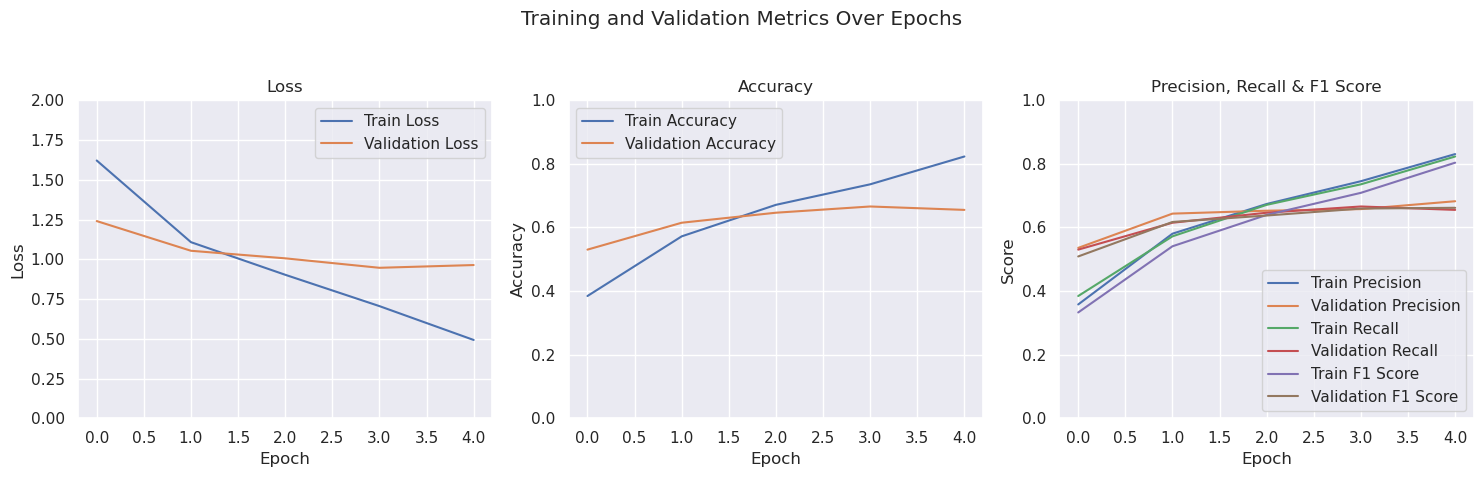

In [48]:
from torchvision import transforms
# Definiere die Transformationspipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Skaliere alle Bilder auf 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_module = ConfigurableDataModule(
    train_data_dir=train_data_path, 
    test_data_dir=our_test_data_path, 
    batch_size=32, 
    train_transform=transform, 
    val_test_transform=transform # Nutzung der gleichen Transformationen
)
model = SimpleCNN(num_classes=9, lr=1e-3)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, version_name="version_0", max_epochs=5, logger_name="simple_CNN", callbacks=callbacks)

### InceptionWasteClassifier

#### Model

In [10]:
from torchvision.models import inception_v3

class Inception_v3_WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = inception_v3(aux_logits=True, weights="Inception_V3_Weights.DEFAULT")
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        if self.training:
            outputs = self.model(x)
            return outputs.logits, outputs.aux_logits
        else:
            return self.model(x)


#### Training

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 98.5MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/Inception_v3
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | Inception3

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.88339 (best 0.88339), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=0-val_loss=0.88.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.50132 (best 0.50132), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=1-val_loss=0.50.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.38620 (best 0.38620), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=2-val_loss=0.39.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.35085 (best 0.35085), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=3-val_loss=0.35.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.30652 (best 0.30652), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=4-val_loss=0.31.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' reached 0.31930 (best 0.30652), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=5-val_loss=0.32.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' reached 0.30196 (best 0.30196), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=6-val_loss=0.30.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' reached 0.30110 (best 0.30110), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=7-val_loss=0.30.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1071: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1190: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1309: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1428: 'val_loss' reached 0.28879 (best 0.28879), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=11-val_loss=0.29.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1547: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1666: 'val_loss' was not in top 2
Restoring states from the checkpoint path at /home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=11-val_loss=0.29.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/Inception_v3_WasteClassifier/models/epoch=11-val_loss=0.29.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃            Test metric            ┃           DataLoader 0            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         our_test_data_acc         │        0.6440404057502747         │
│         our_test_data_f1          │        0.6322437524795532         │
│        our_test_data_loss         │        1.2112675905227661         │
│      our_test_data_precision      │        0.6818323731422424         │
│       our_test_data_recall        │        0.6320754289627075         │
│ test_avg_inference_time_per_image │       0.0018397982930764556       │
└───────────────────────────────────┴───────────────────────────────────┘

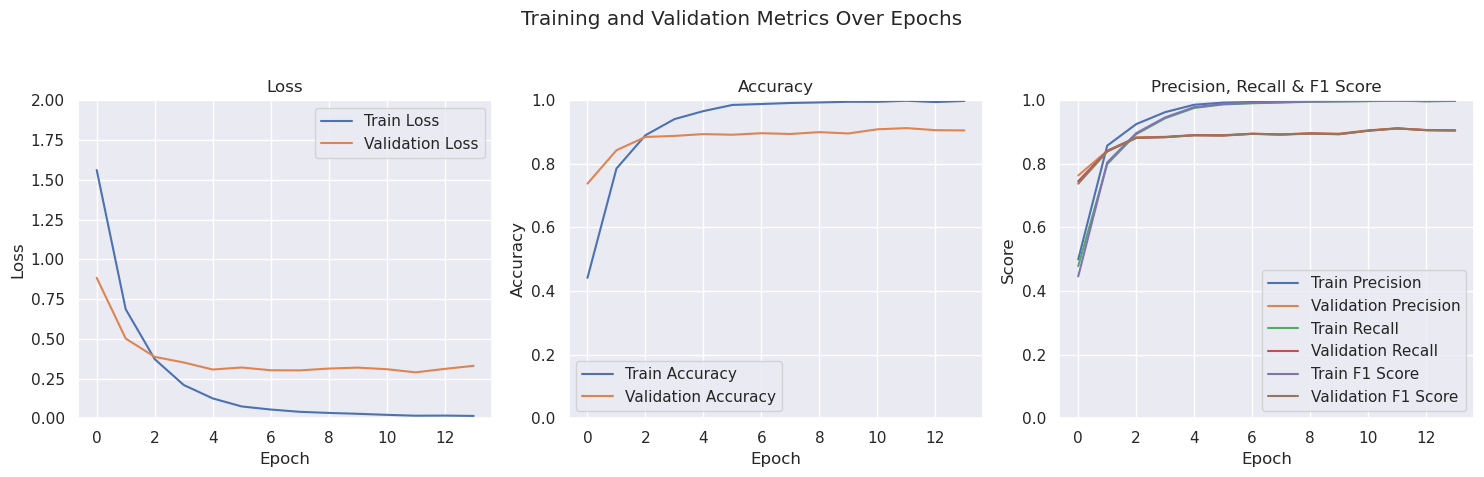

In [11]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(342, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_module = ConfigurableDataModule(
    train_data_dir=train_data_path, 
    test_data_dir=our_test_data_path, 
    batch_size=32, 
    train_transform=transform, 
    val_test_transform=transform # Nutzung der gleichen Transformationen
)

model = Inception_v3_WasteClassifier()
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)

train_model(model, data_module, version_name="version_0", max_epochs=50, logger_name="Inception_v3", callbacks=callbacks)

### DenseNetWasteClassifier

#### Model

In [12]:
from torchvision.models import densenet121

class DenseNet201WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = densenet121(weights="DenseNet121_Weights.DEFAULT")
        self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

#### Training

In [13]:
from torchvision.transforms.functional import InterpolationMode
# Define the transformations as per Inception V3's requirements
transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
data_module = ConfigurableDataModule(
    train_data_dir=train_data_path, 
    test_data_dir=our_test_data_path, 
    batch_size=32, 
    train_transform=transform, 
    val_test_transform=transform # Nutzung der gleichen Transformationen
)

model = Inception_v3_WasteClassifier()
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)

train_model(model, data_module, version_name="version_0", max_epochs=50, logger_name="Inception_v3", callbacks=callbacks)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/jovyan/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 92.2MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/densenet201
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | DenseNet            | 7.0 M 
--------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.852    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.64557 (best 0.64557), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=0-val_loss=0.65.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.43692 (best 0.43692), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=1-val_loss=0.44.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.35391 (best 0.35391), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=2-val_loss=0.35.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' reached 0.32544 (best 0.32544), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=3-val_loss=0.33.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' reached 0.30219 (best 0.30219), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=4-val_loss=0.30.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' reached 0.29559 (best 0.29559), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=5-val_loss=0.30.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' reached 0.29266 (best 0.29266), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=6-val_loss=0.29.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' reached 0.29199 (best 0.29199), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/DenseNet201WasteClassifier/models/epoch=7-val_loss=0.29.ckpt' as top 2


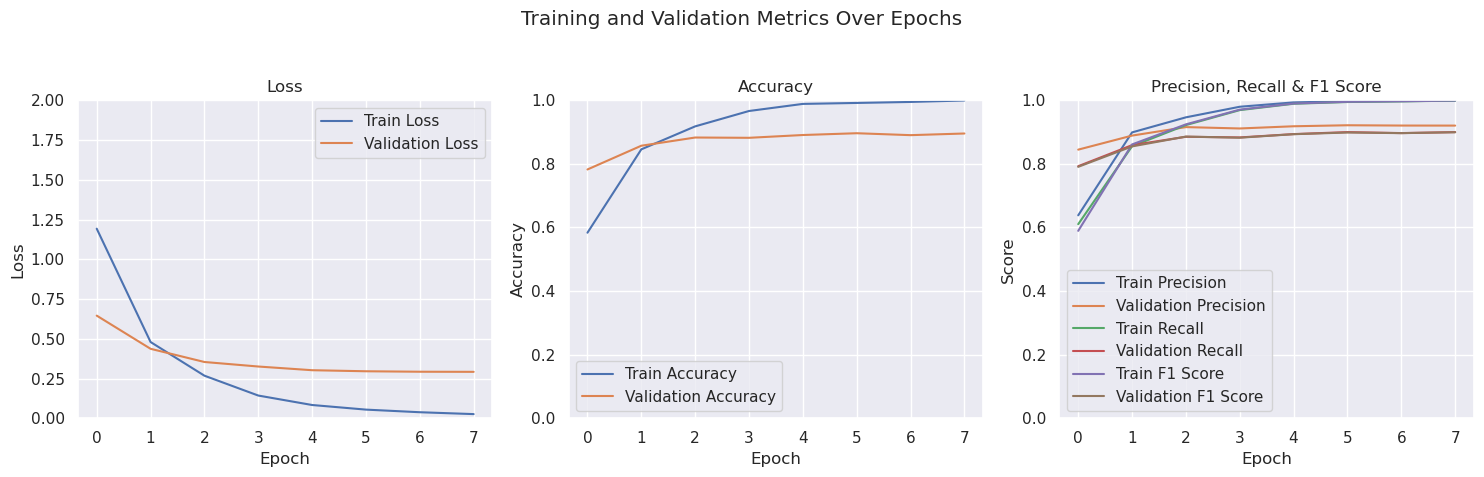

In [14]:
version = "version_standard"

data_module = ConfigurableDataModule(
    train_data_dir=train_data_path, 
    test_data_dir=our_test_data_path, 
    batch_size=32, 
    train_transform=transform, 
    val_test_transform=transform # Nutzung der gleichen Transformationen
)

model = DenseNet201WasteClassifier(num_classes=9)

callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir / version,
    early_stop_patience=2
)

train_model(
    model, 
    data_module, 
    version_name=version, 
    max_epochs=50, 
    logger_name="Inception_v3", 
    callbacks=callbacks
)



### Resnet50

#### Model

In [15]:
from torchvision.models import resnet50

class ResNet50WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = resnet50(weights="ResNet50_Weights.DEFAULT")
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

#### Training

In [16]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = ResNet50WasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="resnet50", callbacks=callbacks)


### VGG16

#### Model

In [18]:
from torchvision.models import vgg16

class VGG16WasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = vgg16(weights="VGG16_Weights.DEFAULT")
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = torch.nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

#### Training

In [19]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.8MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: results/tb_logs/vgg16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | accuracy  | MulticlassAccuracy  | 0     
1 | precision | MulticlassPrecision | 0     
2 | recall    | MulticlassRecall    | 0     
3 | f1_score  | MulticlassF1Score   | 0     
4 | model     | VGG                 | 134 M 
--------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.190   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 119: 'val_loss' reached 0.56719 (best 0.56719), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=0-val_loss=0.57.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 238: 'val_loss' reached 0.45097 (best 0.45097), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=1-val_loss=0.45.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 357: 'val_loss' reached 0.45695 (best 0.45097), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=2-val_loss=0.46.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 476: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 595: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 714: 'val_loss' reached 0.41558 (best 0.41558), saving model to '/home/jovyan/work/Sonstiges/Module/Machine_Learning/RealWaste/results/VGG16WasteClassifier/models/epoch=5-val_loss=0.42.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 833: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 952: 'val_loss' was not in top 2


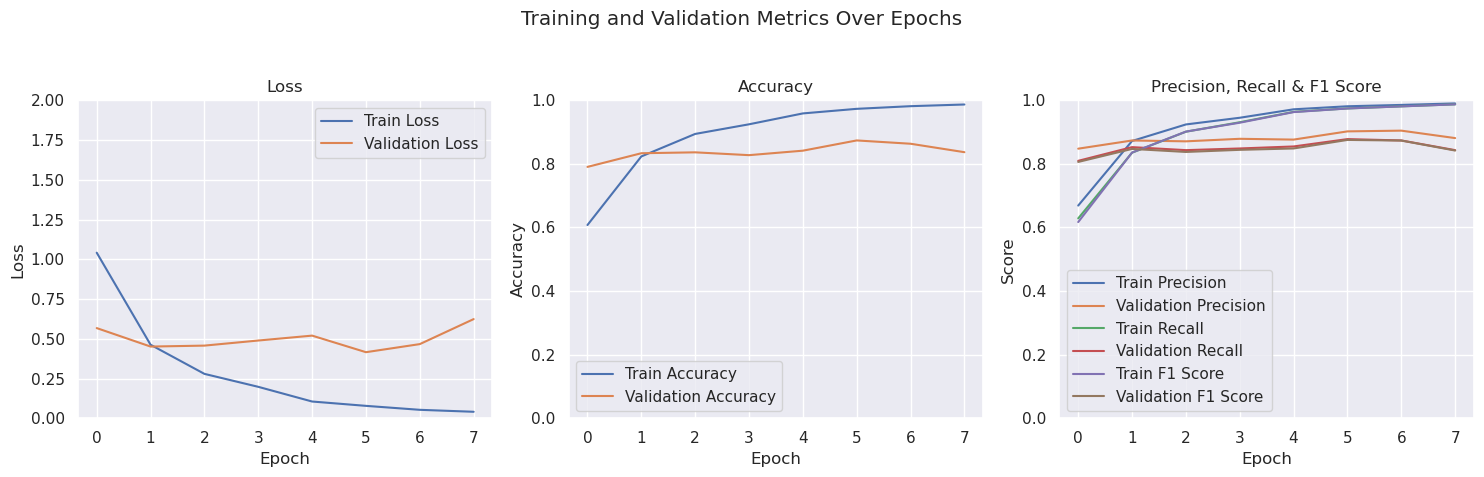

In [20]:
data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = VGG16WasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="vgg16", callbacks=callbacks)


### Vision Transformer

[Torchvision: Vision Transformer](https://pytorch.org/vision/main/models/vision_transformer.html)

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020). An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint [arXiv:2010.11929](https://arxiv.org/abs/2010.11929).

In [40]:
from torchvision.models import vit_l_16

print(vit_l_16())

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

Aus der Modellarchitektor geht hervor, dass die Klassifizierung mit den Extrahierten Features in der letzten Schicht stattfindet. In der Orginalen Architektur werden 768 features mit 1000 Neuronen verbunden, welche die Klassen repräsentieren. Diese können wir austauschen, sodass diese Schicht die 768 Features mit unseren 9 Klassen verbindet.

Im nächsten Schritt sollen die oben gelisteten verschiedene Version der Vision Transformer trainiert und getestet werden. Dabei werden jeweils die vortrainierten "DEFAULT" gewichte verwendet. Diese wurden auf alle IMAGENET1K_V1 Datensatz vortrainiert. Bei allen vortrainierten Modellen wurden die gleichen Transformationen benutzt, welche wir direkt über torchvision für die jeweiligen Gewichte abrufen können 

Russakovsky, O., Deng, J., Su, H., Krause, J., Satheesh, S., Ma, S., ... & Fei-Fei, L. (2015). Imagenet large scale visual recognition challenge. International journal of computer vision, 115, 211-252.

#### Model

In [ ]:
from torchvision.models import vit_l_16

class VitWasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = vit_l_16(weights="ViT_L_16_Weights.IMAGENET1K_V1")
        in_features = self.model.heads.head.in_features
        self.model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)

    def forward(self, x):
        return self.model(x)

#### Training

In [ ]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(242, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
data_module = ConfigurableDataModule(
    train_data_dir=train_data_path, 
    test_data_dir=our_test_data_path, 
    batch_size=32, 
    train_transform=transform, 
    val_test_transform=transform # Nutzung der gleichen Transformationen
)
model = VitWasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(
    model, 
    data_module, 
    version_name="standard", # Hinweise auf Version mit Standardeinstellungen/Transformationen
    max_epochs=10, 
    logger_name="ViT_L_16", 
    callbacks=callbacks
)

### AlexNet

#### Model

In [ ]:
from torchvision.models import alexnet

class AlexNetWasteClassifier(BaseWasteClassifier):
    def __init__(self, num_classes=9):
        super().__init__(num_classes)
        self.model = alexnet(weights="AlexNet_Weights.DEFAULT")
        in_features = self.model.classifier[6].in_features
        self.model.classifier[6] = torch.nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

#### Training

In [ ]:
from torchvision.transforms.functional import InterpolationMode

transform = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_module = ConfigurableDataModule(data_dir=data_path, batch_size=32, transform=transform)

model = AlexNetWasteClassifier(num_classes=9)
callbacks = get_callbacks(
    model_checkpoint_path=model.models_dir,
    early_stop_patience=2
)
train_model(model, data_module, max_epochs=50, logger_name="AlexNet", callbacks=callbacks)

## Augmentierungen und Hpyterparameter Tuning mit Vision Transformer

In [45]:
import torch
from torchvision import transforms
from torchvision.models import vit_l_16
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import optuna
from optuna.integration import PyTorchLightningPruningCallback

# Assuming the definition of ConfigurableDataModule and other necessary imports are done above

class VitWasteClassifier(pl.LightningModule):
    def __init__(self, num_classes=9, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = vit_l_16(weights="ViT_L_16_Weights.DEFAULT")
        in_features = self.model.heads.head.in_features
        self.model.heads.head = torch.nn.Linear(in_features=in_features, out_features=num_classes)

    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate, momentum=0.9)
        return optimizer

def objective(trial):
    # Suggest values for the hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    brightness = trial.suggest_float('brightness', 0.0, 0.2)
    contrast = trial.suggest_float('contrast', 0.0, 0.2)
    saturation = trial.suggest_float('saturation', 0.0, 0.2)
    shear = trial.suggest_float('shear', 5, 25)  # Adding shear as a hyperparameter

    # Define transformations with trial hyperparameters
    transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=0, shear=shear),  # Apply shearing here
        transforms.Resize(242, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Setup the data module and model with suggested hyperparameters
    data_module = ConfigurableDataModule(data_dir=data_path, batch_size=batch_size, transform=transform)

    model = VitWasteClassifier(num_classes=9, learning_rate=learning_rate)
    
    # Define callbacks for early stopping and model checkpointing
    callbacks = get_callbacks(
        model_checkpoint_path=model.models_dir,
        early_stop_patience=2
    )
    # Optune frühzeitiges Abbrechen von nicht viel versprechende Versuchens
    callbacks.append(PyTorchLightningPruningCallback(trial, monitor="val_loss"))
    
    # Setup the trainer
    trainer = Trainer(
        max_epochs=8,  
        gpus=1 if torch.cuda.is_available() else 0,
        logger=TensorBoardLogger("results/tb_logs", name="vit_waste"),
        callbacks=callbacks,
        progress_bar_refresh_rate=0,
    )
    
    # Train the model
    trainer.fit(model, datamodule=data_module)
    
    # Optional: Implement your logic to compute a metric to optimize
    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"  {key}: {value}")


[I 2024-02-27 13:15:58,378] A new study created in memory with name: no-name-46882c23-15fa-4d32-9062-167a4edac396
/tmp/ipykernel_10074/3724756107.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[W 2024-02-27 13:15:58,381] Trial 0 failed with parameters: {'batch_size': 32, 'learning_rate': 0.0001372031687092148, 'brightness': 0.07870164166603355, 'contrast': 0.05271247727212596, 'saturation': 0.0765234697278498, 'shear': 7.119189283423652} because of the following error: NameError("name 'data_path' is not defined").
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_10074/3724756107.

NameError: name 'data_path' is not defined